# Import

In [1]:
# extensions for jupyter notebook
#reload install packages w/o restartting kernel
%load_ext autoreload 
%autoreload 2
#plots display in the cell
%matplotlib inline
%config InlineBackend.figure_format = 'png'
#faster autocompletion
%config IPCompleter.use_jedi = False 

# data analysis packages
import pandas as pd
import numpy as np

# plotting packages & params for figures
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [2]:
from functions.utils import read_dataset, median_scale, predict_batch
from functions.feature_calc import naming_mapper, gmt_genes_alt_names, ssgsea_formula, run_progeny

import pickle
print(pickle.format_version)

4.0


In [3]:
# Progress bar visualization
from tqdm import tqdm

In [4]:
def get_batch_and_predicitons_for_samples(sample_df, ref_df, batch, k=100):
    batch_pred = {}
    probas = {}
    sc_feats = []
    
    for name, ser in tqdm(sample_df.iterrows()):
        
        ser = ser[(~ser.isna())] # Can't process NaN features
        
        X_ref = ref_df[ser.index].dropna() # Same set of features; be consious, classifier only take full set of features!
    
        ident_batch = predict_batch(ser, X_ref, batch, k=k) #Higher k will produce better results
        batch_pred[name] = ident_batch
    
        ref_coh = X_ref[batch==ident_batch]
        
        scaled_features = median_scale(pd.concat([ref_coh,ser.to_frame().T])) #concat with identified cohort and scale
        scaled_features = scaled_features.loc[name]
        
        prob = model.predict_proba(scaled_features.to_frame().T)
        probas[name] = list(prob[0])

        sc_feats.append(scaled_features.to_frame())
    
    batch_pred = pd.Series(batch_pred)
    probas = pd.DataFrame(probas)
    probas.index = model.classes_ 
    
    probas.loc['Unclassified'] = 0
    probas.loc['Unclassified',probas.columns[probas[probas>0.47].isna().all()]] = 1 # Set threshold
    
    class_predict = probas.idxmax()

    sc_feats = pd.concat(sc_feats, axis=1).T
    
    return batch_pred, probas, class_predict, sc_feats

# Data

Prepare your sample according to the [guidelines](https://github.com/BostonGene/Immune_Escape/blob/main/DATA_AND_QC.md) (take required transcripts, perform QC), then load: 

In [5]:
cohort_name = 'QC_example_SKCM_HugoMAPK2_GSE75313'

expression = read_dataset('test_data/QC_example_SKCM_HugoMAPK2_GSE75313/output/expressions_refined.tsv.gz')
expression.head()

SRX1446796  SRX1446797  SRX1446798  SRX1446799  SRX1446800  \
Gene                                                                  
A1BG       0.000000    0.000000    0.073078    0.046100    0.000000   
A1CF       0.000000    0.000000    0.016818    0.032895    0.018860   
A2M        8.315325    8.688029    7.213757    8.189954    9.775147   
A2ML1      1.939184    3.383156    5.002732    5.324455    0.676129   
A3GALT2    0.000000    0.080243    0.000000    0.000000    0.800559   

         SRX1446801  SRX1446802  SRX1446803  SRX1446804  SRX1446805  \
Gene                                                                  
A1BG       0.000000    0.031377    0.000000    0.000000    0.000000   
A1CF       0.030272    0.020603    0.018773    0.015271    0.003989   
A2M        9.202142    8.738409    8.469137    9.093775   10.379255   
A2ML1      0.108234    1.979346    1.943242    0.596630    0.193554   
A3GALT2    0.293649    0.000000    0.029331    0.000000    0.000000   

         SRX1446808  SRX1446809  SRX1446810  SRX1446811  SRX1446812  \
Gene                                                                  
A1BG       0.000000    0.000000    0.000000    0.000000    0.360252   
A1CF       0.027835    0.018157    0.042922    0.018590    0.000000   
A2M        8.937630    9.948894    8.181539    8.152129    8.168005   
A2ML1      0.180695    0.083906    0.308971    0.130943    0.519393   
A3GALT2    0.000000    0.705637    0.000000    0.061043    0.476854   

         SRX3173615  SRX3173616  SRX3173617  
Gene                                         
A1BG       0.125111    0.000000    0.185589  
A1CF       0.081888    0.052673    0.071418  
A2M        7.846306    8.958495    9.082054  
A2ML1      3.735812    0.518568    4.607811  
A3GALT2    0.786077    0.556590    0.659706

In [6]:
# Load gmt and progeny coefficients from pickle

with open('model/IE_clusters.pickle', 'rb') as f:
    ie_dict = pickle.load(f)

feature_list = ie_dict['X'].columns.to_list()

gmt = ie_dict['gmt_dict']
gmt = gmt_genes_alt_names(gmt, expression.index, verbose=True)

prog_coeffs = ie_dict['progeny_coeffs'].reset_index()

Matched: 356
Trying to find new names for 1 genes in 19706 known


1 input query terms found dup hits:	[('TRBC1', 2)]


1 genes were not converted


## Load metacohort for mapping

In [7]:
sc_features_meta = read_dataset('data/Metacohort_full_scaled_features.tsv.gz').rename(columns=naming_mapper)[feature_list+['Batch']]
ie_class_meta = read_dataset('data/Metacohort_full_class_prediction.tsv.gz', usecols=[0,11]).ie_class

# Calculate features and classify

Load model, FGES and PROGENy coefficients; calculate features, classify

In [12]:
# Load pre-treained model
with open('model/ovr_knn_calibrated.pickle', 'rb') as f:
    model = pickle.load(f)

In [8]:
# Calculate ssgsea
ssgsea_df = ssgsea_formula(expression.T, gmt)

# Calculate progeny
progen_df = run_progeny(expression, prog_coeffs=prog_coeffs).T

In [21]:
#Concat and scale
features_df = pd.concat([ssgsea_df, progen_df], axis=1)[feature_list]

sc_feats = median_scale(features_df)
sc_feats.head()

Metabolic suppression of CTL   B cells  M1 cytokines  Treg cells  \
SRX1446796                      0.069675  0.024455     -0.944946    0.126476   
SRX1446797                      1.195178  0.182979     -0.054777    0.642207   
SRX1446798                     -0.986903 -0.993911     -1.400009    1.077255   
SRX1446799                     -0.420325 -0.024455     -2.022776    1.304127   
SRX1446800                     -0.891818  0.912996      0.680772   -1.242626   

                 pDC   T cells    TLS_NL  Anti-tumor chemokines  \
SRX1446796  0.757857 -0.288227 -0.038269               0.088420   
SRX1446797  0.211612  0.371952  0.038269              -0.035513   
SRX1446798 -0.249431  0.288123  0.145429              -0.577962   
SRX1446799 -0.806720  0.117029 -1.035235              -1.233915   
SRX1446800 -0.002425 -1.451348  0.211403               0.321891   

            Lymphoid_checkpoints  NK cells  ...  Adipocytes      EGFR  \
SRX1446796              0.154090 -0.670755  ...    1.836675  2.444682   
SRX1446797             -0.030498  0.229294  ...    1.806927 -0.342872   
SRX1446798             -0.511346 -1.015969  ...   -0.613187  1.920297   
SRX1446799             -1.589106 -1.414326  ...    1.313482 -1.093737   
SRX1446800             -1.034654 -0.774310  ...    0.240394  0.617005   

                MAPK   Hypoxia  Hypoxia_factors  Glycolysis      PI3K  \
SRX1446796  0.118713 -1.054464        -1.391913    0.130509 -0.003903   
SRX1446797 -2.513875 -0.974908        -0.110506   -0.627826  1.388345   
SRX1446798 -0.230363  0.455228         0.800224   -0.017165 -0.636831   
SRX1446799 -1.954899  0.223416         1.829501   -1.821552  1.923439   
SRX1446800  1.086422  1.079944        -0.377093   -1.524797 -2.799632   

            Autophagy  Acidosis  Proliferation_rate  
SRX1446796  -3.742143 -1.060673            1.867841  
SRX1446797   0.325531 -3.859857           -0.754150  
SRX1446798  -3.229974  1.733557            1.689433  
SRX1446799  -0.379702 -3.540642           -0.314588  
SRX1446800  -0.927027  3.960909            0.234223  

[5 rows x 45 columns]

In [22]:
#Predict
probas = pd.DataFrame(data=model.predict_proba(sc_feats), index=sc_feats.index)
probas.columns = model.classes_

#Cutoff for class prediction
probas.loc[probas[probas>0.47].isna().all(axis=1), 'Unclassified'] = 1

class_predict = probas.idxmax(axis=1)

class_predict.value_counts()

Immune Desert                       4
Highly Immune-Enriched, Inflamed    4
Fibrotic, Angiogenic, Myeloid       3
Immune-Enriched, Fibrotic           2
Fibrotic, Hypoxic                   2
B-Cell-Enriched, Angiogenic         1
Unclassified                        1
Immune-Enriched, Hypoxic            1
dtype: int64

In [23]:
class_predict.to_csv('test_data/QC_example_SKCM_HugoMAPK2_GSE75313/output/class_prediction_cohort_scaling.tsv', sep='\t')

# Visualize

In [15]:
from functions.plotting import *

## Prediction results

Text(0.5, 1.0, 'Predicted IE class')

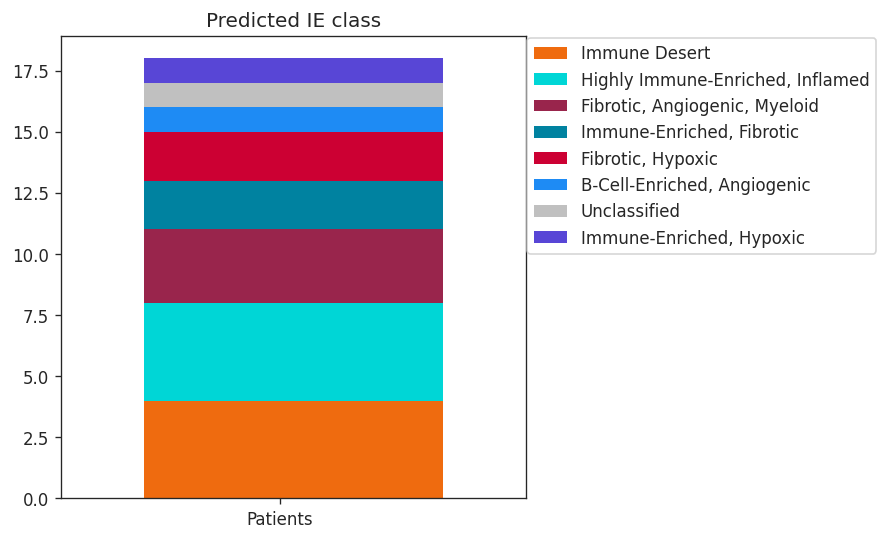

In [17]:
plot_data = class_predict.value_counts().to_frame().T
plot_data.index = ['Patients']
bot_bar_plot(plot_data, palette=ie_palette)
plt.title('Predicted IE class')

## Metacohort mapping

In [18]:
def highlight_predicted_samples(c_grouping, data_tr, pal, ax, label_samples=True, s=20):

    ind = c_grouping.index&data_tr.index
    data = data_tr.loc[ind]
    
    texts = [] if label_samples else None
    X = []
    Y = []
    
    for name, row in data.iterrows():
        x, y = row.loc[0], row.loc[1]
        c_color = pal[c_grouping.loc[name]]

        ax.scatter(x, y, color=c_color, s=s, edgecolors='black')

        if label_samples:
            texts.append(ax.text(x, y, s=str(name), fontsize=7, bbox=dict(facecolor='white', boxstyle='round,pad=0.01', alpha=0.4)))
        
        X.append(x)
        Y.append(y)

    if label_samples:
        adjust_text(
            texts, x=X, y=Y, arrowprops=dict(arrowstyle='-', color='black', lw=1), ax=ax
        )

In [29]:
def dr_plots(labels, pal, label_samples=True, cohort_s = 20):
    af = axis_net(2, 1, title = f'Mapping {cohort_name}, N={N_coh} to {N_metacoh} cohort\n{len(feature_list)} MAD-scaled feature space', x_len=7)

    ax= next(af)
    _, data_tr_pca, model_pca = pca_plot(plot_df, labels, title=f"PCA, linear and robust", ax=ax, legend=False, s=2, palette=pal, return_model=True)
    
    highlight_predicted_samples(labels.loc[cohort_labels.index], data_tr_pca, pal, ax=ax, label_samples=label_samples, s=cohort_s)
    
    ax= next(af)
    _, data_tr_umap, model_umap = umap_plot(plot_df, labels, title=f"UMAP, nicer visualization", ax=ax, legend='out', s=2, palette=pal, return_model=True)
    
    highlight_predicted_samples(labels.loc[cohort_labels.index], data_tr_umap, pal, ax=ax, label_samples=label_samples, s=cohort_s)
    
    plt.tight_layout(pad=0.1)

In [30]:
plot_df = pd.concat([sc_features_meta, sc_feats]).iloc[:,:-1].clip(-4,4)

N_metacoh = len(sc_features_meta)
N_coh = len(sc_feats)

In [31]:
cohort_labels = pd.Series(index=sc_feats.index, data=[cohort_name]*N_coh)
cohort_type_labels = pd.concat([pd.Series(index=sc_features_meta.index, data=['Metacohort']*N_metacoh), cohort_labels])

coh_palette = {'Metacohort':'lightgray', cohort_name:'crimson'}

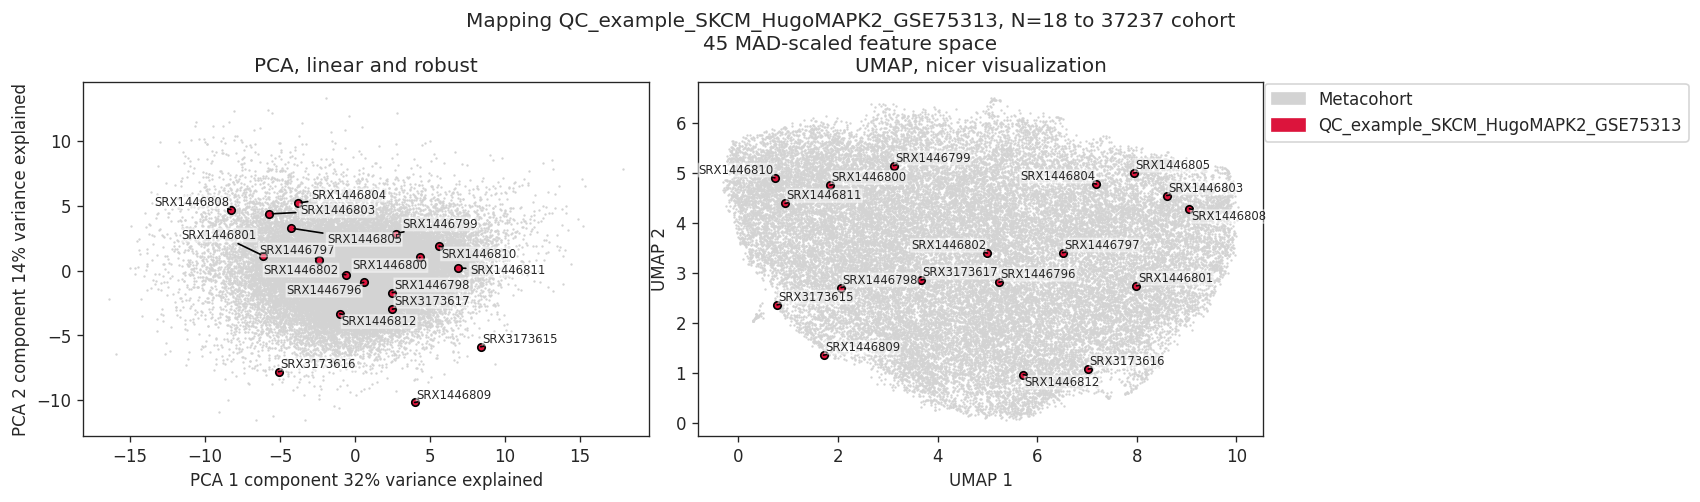

In [32]:
labels, pal = cohort_type_labels, coh_palette
dr_plots(labels, pal, label_samples=True)

In [33]:
class_labels = pd.concat([ie_class_meta, class_predict])

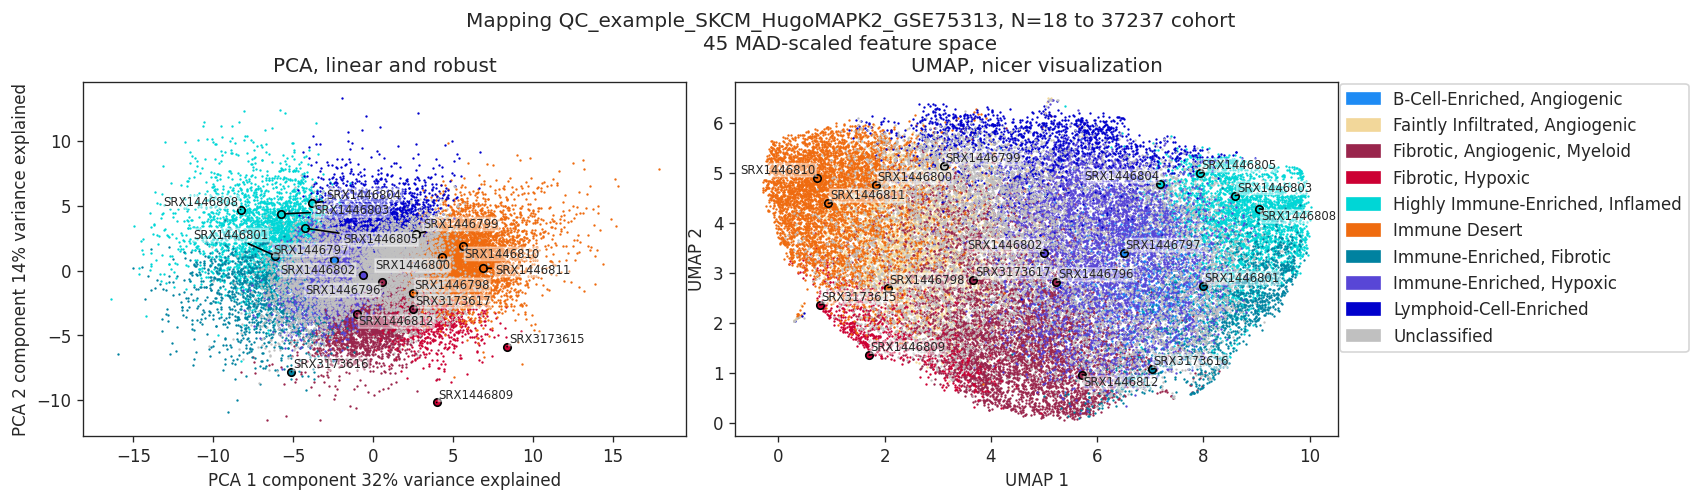

In [34]:
labels, pal = class_labels, ie_palette
dr_plots(labels, pal, label_samples=True)